In [15]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import operator
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import pydotplus

from util.api import get_pkgs_usage_count

%matplotlib inline
plt.style.use('classic')

In [16]:
lts_list = ['0-7', '2-22', '3-22', '6-35', '7-24', '9-21', '11-22', '12-14', '12-26', '13-11', '13-19', '14-27', '15-3', '16-11']
df_list = []
df_by_category_list = []

for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/lts-{lts}/lts-{lts}.df')
    df_list.append(df)
    
for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/lts-{lts}/lts-{lts}-by-category.df')
    df_by_category_list.append(df)

# Research Questions (RQs)

- **RQ 1.** What packages are the most used? Which of them are outside from the Stackage selection?
- **RQ 2.** How many dependencies of packages are outside from the Stackage selection (in)directly?
- **RQ 3.** How frequently are the packages updated? 

Regarding monads, we analyze the evolution of dependencies of monad modules available in the mtl package:

- **RQ 4.** How has the use of monads evolved?
- **RQ 5.** Are there packages that stopped using monads?


## RQ 1. What packages are the most used? Which of them are outside from the Stackage selection?

Consideramos el ultimo snapshot publicado en Stackage, especificamente el LTS 16.11. Utilizamos el campo **Dependencies** del DataFrame para obtener el listado de las dependencias de cada paquete y construimos un diccionario de todos los paquetes y sus dependencias. Contamos la cantidad de veces que fue requerido cada uno de ellos para posteriormente ordenarlos ascendentemente y filtrar el top 25 de los mas utilizados. Luego, restamos el conjunto de todos los paquetes seleccionados del LTS 16.11 a la lista de los top 25 mas utilizados para obtener los paquetes que no formaron parte de la seleccion.

Descubrimientos:

- Pregunta 1    
    - El top 5 de los paquetes mas usados se mantuvo a lo largo de las 14 versiones LTS analizadas, estos son: base, bytestring, containers, text, and transformers
    - MTL, tiene un rol importante en lenguaje y mantiene el top 6 a lo largo de las versiones consideras
- Pregunta 2
    - Descubrimos que dentro de los 22 paquetes mas usados en las versiones [15-3 y 16-11] se ubica quickchek un libreria utilzia para hacer tests que no se encuentra en la seleccion realizada por stackage
    - Analizando en profundiad este caso, descrubirmos que existen una gran cantidad de paquetes que son utilizados pero no son parte de la seleccion -> (Esto da paso a la pregunta 2) 

In [17]:
top_25_pkgs = []
top_25_count = []
top_25_list = dict()

for idx, lts in enumerate(lts_list):
    top_25 = dict()
    packet_usage_count = get_pkgs_usage_count(df_list[idx])
    ordered_pkgs = sorted(packet_usage_count, key=packet_usage_count.get, reverse=True)[:25]

    for pkg in ordered_pkgs:
        top_25_pkgs.append(pkg)
        top_25_count.append(packet_usage_count[pkg])
        top_25[pkg] = packet_usage_count[pkg]
    
    top_25_list[lts] = top_25 

In [18]:
lista = []
increment = []
y = list(top_25_list['0-7'].values())
num=0
for idx,df in enumerate (top_25_list):
    z = list(top_25_list[df].values())
    lista = []
    num+=1
    for idx,count in enumerate (top_25_list[df]):
        aumento = z[idx]*num
        lista.append(aumento)
    increment.append(lista)

In [19]:
lista = []
increment = []
y = list(top_25_list['0-7'].values())
num=0
for idx,df in enumerate (top_25_list):
    z = list(top_25_list[df].values())
    lista = []
    num+=1
    for idx,count in enumerate (top_25_list[df]):
        aumento = z[idx]*num
        lista.append(aumento)
    increment.append(lista)

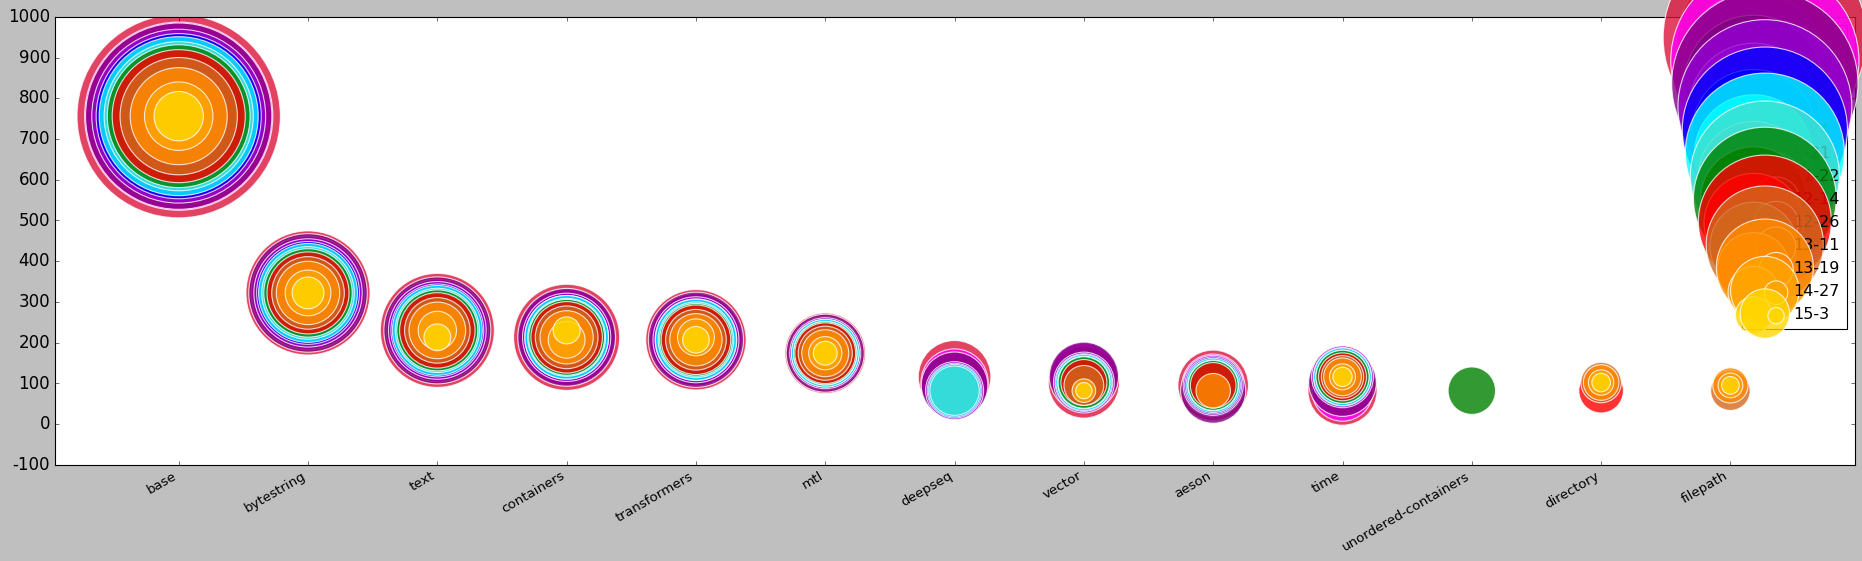

In [20]:
fig,ax = plt.subplots(figsize =(12, 8))
ax.margins(0.080) 
plt.subplots_adjust(right=2)
for idx in range(len(top_25_list)-1,0,-1):
    x = list(top_25_list[lts_list[idx]].keys())[:10]
    y = list(top_25_list['0-7'].values())[:10]
    z = list(top_25_list[lts_list[idx]].values())[:10]
    colors = ['yellow', 'gold', 'orange', 'darkorange', 'chocolate', 'red', 'green', 
              'turquoise', 'cyan', 'blue','darkviolet','purple','magenta','crimson']
    ax.scatter(x, y, s=increment[idx][:10],edgecolors="white",c=colors[idx],alpha=0.8,cmap="Accent")

plt.gcf().autofmt_xdate()

ax.set_yticks([-100,0,100,200, 300, 400, 500,600,700,800,900,1000])
ax.set_yticklabels(['-100','0','100','200', '300', '400', '500','600','700','800','900','1000'],fontsize=15)
plt.legend(lts_list,loc='best',)
plt.savefig("../../graphs/rq1.pdf", format='pdf', bbox_inches='tight')

plt.show()

In [11]:
'''pkg = []
deps = []
df_ltslist = []
colors=['blue','red']
for lts in dictlts:
    df_lts1 = pd.DataFrame()
    top_pkg = list(top_25_list[lts].keys())[1:11]
    for idx, row in df_list[dictlts[lts]].iterrows():
        for dependency in list(row['deps']):
            if dependency in top_pkg:
                pkg.append(row['package'])
                deps.append(dependency)
    df_lts1['package'] = pkg
    df_lts1['deps'] = deps
    df_ltslist.append(df_lts1)
for j in range(len(df_ltslist)):
    def get_coordinates_in_circle(n):
        thetas = [2*np.pi*(float(i)/n) for i in range(n)]
        returnlist = [(np.cos(theta),np.sin(theta)) for theta in thetas]
        return returnlist

    G = nx.from_pandas_edgelist(df_ltslist[j], 'deps', 'package')

    degrees = dict(nx.degree(G))
    nx.set_node_attributes(G, name='degree', values=degrees)

    number_to_adjust_by = 20
    adjusted_node_size = dict([(node, degree*number_to_adjust_by) for node, degree in nx.degree(G)])
    nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)
    size_by_this_attribute = 'adjusted_node_size'

    labeldict = {}
    posdict = {}
    for node in G.nodes():  
        if node in top_pkg:
            labeldict[node] = node

    circular_positions = get_coordinates_in_circle(len(top_pkg))
    fixed_nodes = [n for n in G.nodes() if n in top_pkg]

    pos = {}
    for i,p in enumerate(fixed_nodes):
        pos[p] = circular_positions[i]
    pos = nx.spring_layout(G,pos=pos, fixed=fixed_nodes)
    
    plt.figure(figsize=(12,8))
    color = (0.1, 0.1, 0.1, 0.5)
    nx.draw(G,pos=pos,label=True, labels=labeldict,node_size=list(adjusted_node_size.values()),
                   edgecolors='white',width=0.5,edge_color=color,node_color=colors[j])

plt.savefig("../graphs/rq1.pdf", format='pdf', bbox_inches='tight')
plt.show()'''

'pkg = []\ndeps = []\ndf_ltslist = []\ncolors=[\'blue\',\'red\']\nfor lts in dictlts:\n    df_lts1 = pd.DataFrame()\n    top_pkg = list(top_25_list[lts].keys())[1:11]\n    for idx, row in df_list[dictlts[lts]].iterrows():\n        for dependency in list(row[\'deps\']):\n            if dependency in top_pkg:\n                pkg.append(row[\'package\'])\n                deps.append(dependency)\n    df_lts1[\'package\'] = pkg\n    df_lts1[\'deps\'] = deps\n    df_ltslist.append(df_lts1)\nfor j in range(len(df_ltslist)):\n    def get_coordinates_in_circle(n):\n        thetas = [2*np.pi*(float(i)/n) for i in range(n)]\n        returnlist = [(np.cos(theta),np.sin(theta)) for theta in thetas]\n        return returnlist\n\n    G = nx.from_pandas_edgelist(df_ltslist[j], \'deps\', \'package\')\n\n    degrees = dict(nx.degree(G))\n    nx.set_node_attributes(G, name=\'degree\', values=degrees)\n\n    number_to_adjust_by = 20\n    adjusted_node_size = dict([(node, degree*number_to_adjust_by) for n

In [12]:
pkg = []
deps = []
df_lts1 = pd.DataFrame()
top_pkg = list(top_25_list['16-11'].keys())[1:11]
for idx, row in df_list[13].iterrows():
    for dependency in list(row['deps']):
        if dependency in top_pkg:
            pkg.append(row['package'])
            deps.append(dependency)
df_lts1['package'] = pkg
df_lts1['deps'] = deps


In [13]:
def get_coordinates_in_circle(n):
    thetas = [2*np.pi*(float(i)/n) for i in range(n)]
    returnlist = [(np.cos(theta),np.sin(theta)) for theta in thetas]
    return returnlist

G = nx.from_pandas_edgelist(df_lts1, 'deps', 'package')

degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

number_to_adjust_by = 8
adjusted_node_size = dict([(node, degree*number_to_adjust_by) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)
size_by_this_attribute = 'adjusted_node_size'

labeldict = {}
posdict = {}
for node in G.nodes():  
    if node in top_pkg:
        labeldict[node] = node

circular_positions = get_coordinates_in_circle(len(top_pkg))
fixed_nodes = [n for n in G.nodes() if n in top_pkg]

pos = {}
for i,p in enumerate(fixed_nodes):
    pos[p] = circular_positions[i]

pos = nx.spring_layout(G,pos=pos, fixed=fixed_nodes,scale=5)

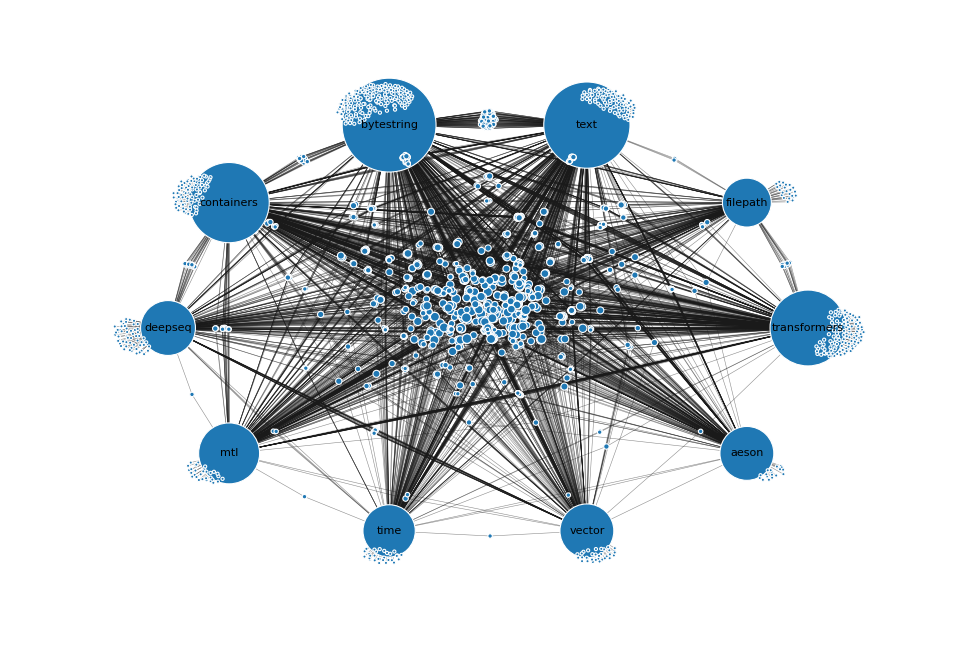

In [14]:
plt.figure(figsize=(12,8))
color = (0.1, 0.1, 0.1, 0.5)
nx.draw(G,pos=pos,label=True, labels=labeldict,node_size=list(adjusted_node_size.values()),
               edgecolors='white',width=0.5,edge_color=color,font_size=10)

plt.savefig("../../graphs/rq1.pdf", format='pdf', bbox_inches='tight')
plt.show()